# Stock Risk Intelligence Platform — Complete Analysis

## Executive Summary
This notebook documents the end-to-end analysis behind a real-time stock risk monitoring platform. It covers data collection, exploratory analysis, feature engineering, ML modeling, and model explainability for a portfolio of 48 tech stocks.

### Key Results
| Component | Metric | Result |
|-----------|--------|--------|
| Risk Classifier (XGBoost) | AUC-ROC | **0.73** |
| Risk Classifier (XGBoost) | CV AUC | **0.86 ± 0.025** |
| SHAP Explainability | Stocks Explained | **48/48** |
| Volatility Forecast (GARCH) | Directional Accuracy | **79%** |
| Volatility Forecast (LSTM) | MAE | **0.128** |
| Sentiment Analysis (FinBERT) | Articles Analyzed | **400+** |

### Architecture
```
Yahoo Finance → Data Pipeline → Feature Engineering (34 features)
                                        ↓
                XGBoost Risk Classifier (AUC 0.73)
                SHAP Explainability (per-stock drivers)
                GARCH/LSTM Volatility Forecasting
                FinBERT Sentiment Analysis
                RAG AI Assistant (Groq llama-3.3-70B)
                                        ↓
                React Dashboard ← Flask API ← PostgreSQL
```

In [1]:
# ============================================================
# 1. IMPORTS & DATA LOADING
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from scipy import stats
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

SYMBOLS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'NFLX',
    'ADBE', 'CRM', 'ORCL', 'CSCO', 'INTC', 'AMD', 'QCOM', 'TXN',
    'AVGO', 'INTU', 'AMAT', 'LRCX', 'MU', 'KLAC', 'SNPS', 'CDNS',
    'MCHP', 'MRVL', 'NXPI', 'ADI', 'SWKS', 'QRVO', 'UBER', 'ABNB',
    'SNOW', 'ZM', 'DOCU', 'SHOP', 'COIN', 'RBLX', 'DDOG', 'NET',
    'CRWD', 'ZS', 'PANW', 'FTNT', 'OKTA', 'NOW', 'WDAY', 'TEAM',
]

SECTORS = {
    'FAANG+': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'NFLX'],
    'Semiconductors': ['INTC', 'AMD', 'QCOM', 'TXN', 'AVGO', 'AMAT', 'LRCX', 'MU', 'KLAC', 'SNPS', 'CDNS', 'MCHP', 'MRVL', 'NXPI', 'ADI', 'SWKS', 'QRVO'],
    'SaaS/Cloud': ['ADBE', 'CRM', 'ORCL', 'SNOW', 'DDOG', 'NET', 'CRWD', 'ZS', 'PANW', 'FTNT', 'OKTA', 'NOW', 'WDAY', 'TEAM', 'DOCU', 'INTU', 'ZM'],
    'Consumer Tech': ['UBER', 'ABNB', 'SHOP', 'COIN', 'RBLX', 'CSCO'],
}

SECTOR_COLORS = {'FAANG+': 'steelblue', 'Semiconductors': 'forestgreen', 'SaaS/Cloud': 'orange', 'Consumer Tech': 'indianred'}

symbol_to_sector = {}
for sector, syms in SECTORS.items():
    for s in syms:
        symbol_to_sector[s] = sector

ALL_TICKERS = SYMBOLS + ['SPY']
print(f'Downloading data for {len(ALL_TICKERS)} tickers...')
raw_data = yf.download(ALL_TICKERS, period='5y', interval='1d', group_by='ticker', auto_adjust=True)

records = []
for symbol in ALL_TICKERS:
    try:
        df = raw_data[symbol].dropna(subset=['Close']).reset_index()
        df['symbol'] = symbol
        df.columns = [c.lower() if c != 'symbol' else c for c in df.columns]
        records.append(df[['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']])
    except:
        pass

data = pd.concat(records, ignore_index=True)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['symbol', 'date']).reset_index(drop=True)

print(f'Total records: {len(data):,}')
print(f'Date range: {data.date.min().date()} to {data.date.max().date()}')
print(f'Stocks: {data.symbol.nunique()}')

[*********************100%***********************]  49 of 49 completed


Total records: 61,443
Date range: 2021-02-18 to 2026-02-17
Stocks: 49


---
## 2. Data Quality & Cleaning

In [2]:
# Missing values and trading days per stock
print('Missing values per column:')
print(data.isnull().sum())

stock_counts = data.groupby('symbol').size().sort_values()
print(f'\nTrading days per stock:')
print(f'  Min: {stock_counts.min()} ({stock_counts.idxmin()})')
print(f'  Max: {stock_counts.max()} ({stock_counts.idxmax()})')
print(f'  Mean: {stock_counts.mean():.0f}')

recent_ipos = stock_counts[stock_counts < stock_counts.quantile(0.25)]
if len(recent_ipos) > 0:
    print(f'\nStocks with limited history:')
    for sym, count in recent_ipos.items():
        first_date = data[data['symbol'] == sym]['date'].min().date()
        print(f'  {sym}: {count} days (first date: {first_date})')

print(f'\nInvalid prices (close <= 0): {len(data[data["close"] <= 0])}')

Missing values per column:
symbol    0
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

Trading days per stock:
  Min: 1217 (COIN)
  Max: 1255 (ADBE)
  Mean: 1254

Stocks with limited history:
  COIN: 1217 days (first date: 2021-04-14)
  RBLX: 1241 days (first date: 2021-03-10)

Invalid prices (close <= 0): 0


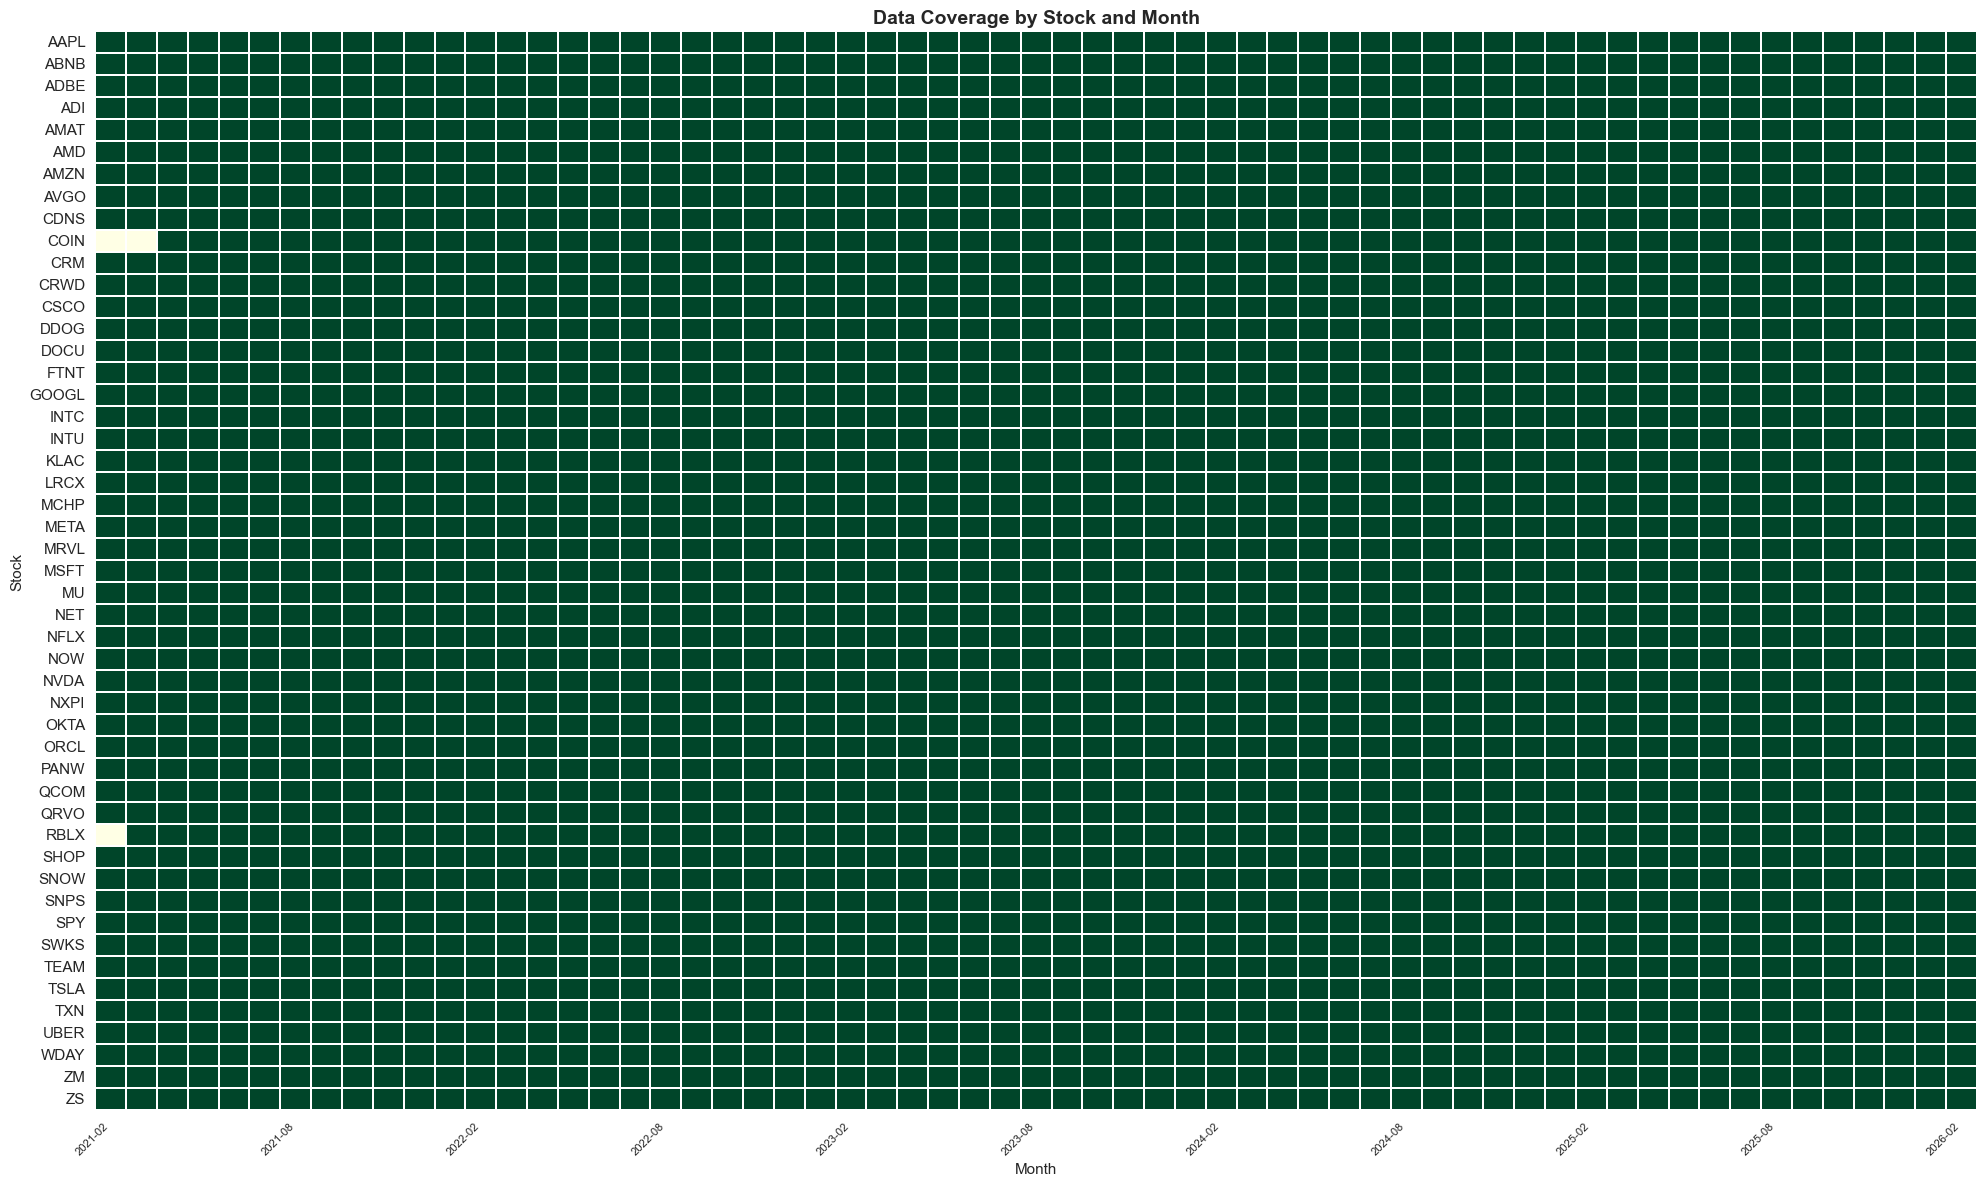

In [3]:
# Data coverage heatmap
pivot = data.pivot_table(index='symbol', columns=data['date'].dt.to_period('M'), values='close', aggfunc='count')
pivot = pivot.fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(pivot > 0, cmap='YlGn', cbar=False, ax=ax, linewidths=0.1)
ax.set_title('Data Coverage by Stock and Month', fontweight='bold', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Stock')
xtick_labels = [str(p) if i % 6 == 0 else '' for i, p in enumerate(pivot.columns)]
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.savefig('data_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Return Analysis

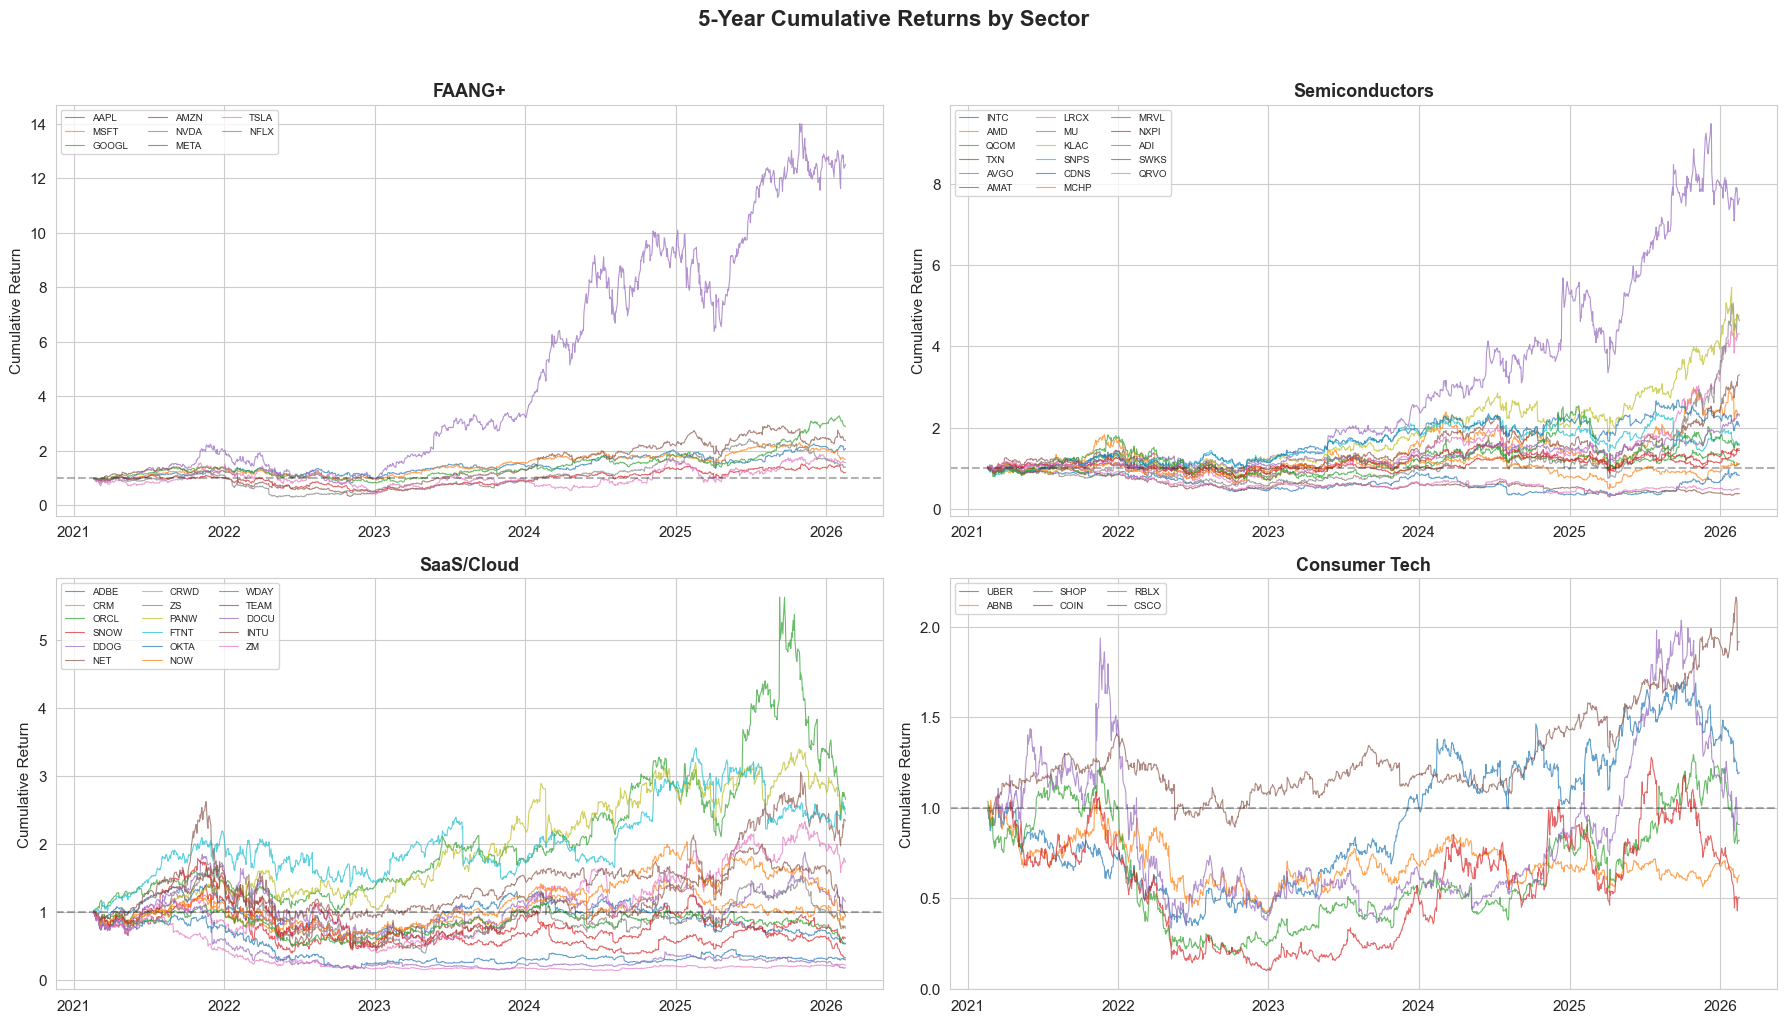

In [4]:
# Compute returns
stock_data = data[data['symbol'] != 'SPY'].copy()
stock_data['daily_return'] = stock_data.groupby('symbol')['close'].pct_change()
stock_data['log_return'] = np.log(stock_data['close'] / stock_data.groupby('symbol')['close'].shift(1))
stock_data['sector'] = stock_data['symbol'].map(symbol_to_sector)

# Cumulative returns by sector
cum_returns = stock_data.groupby('symbol').apply(
    lambda g: (1 + g.set_index('date')['daily_return'].dropna()).cumprod()
).reset_index()
cum_returns.columns = ['symbol', 'date', 'cum_return']

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
for idx, (sector, syms) in enumerate(SECTORS.items()):
    ax = axes[idx // 2, idx % 2]
    for sym in syms:
        sdf = cum_returns[cum_returns['symbol'] == sym]
        if len(sdf) > 0:
            ax.plot(sdf['date'], sdf['cum_return'], linewidth=0.8, alpha=0.7, label=sym)
    ax.set_title(f'{sector}', fontweight='bold', fontsize=13)
    ax.set_ylabel('Cumulative Return')
    ax.axhline(y=1, color='black', linestyle='--', alpha=0.3)
    ax.legend(fontsize=7, ncol=3, loc='upper left')

plt.suptitle('5-Year Cumulative Returns by Sector', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cumulative_returns.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Return distribution statistics
return_stats = stock_data.groupby('symbol')['daily_return'].agg(
    mean='mean', std='std', skew='skew',
    kurtosis=lambda x: x.kurtosis(), min='min', max='max'
).round(4)

return_stats['annualized_return'] = (return_stats['mean'] * 252).round(4)
return_stats['annualized_vol'] = (return_stats['std'] * np.sqrt(252)).round(4)
return_stats['sharpe'] = (return_stats['annualized_return'] / return_stats['annualized_vol']).round(3)
return_stats['sector'] = return_stats.index.map(symbol_to_sector)

print('Top 10 by Sharpe Ratio:')
print(return_stats.nlargest(10, 'sharpe')[['annualized_return', 'annualized_vol', 'sharpe', 'skew', 'kurtosis', 'sector']].to_string())
print('\nBottom 10 by Sharpe Ratio:')
print(return_stats.nsmallest(10, 'sharpe')[['annualized_return', 'annualized_vol', 'sharpe', 'skew', 'kurtosis', 'sector']].to_string())

Top 10 by Sharpe Ratio:
        annualized_return  annualized_vol  sharpe    skew  kurtosis          sector
symbol                                                                             
NVDA               0.6300          0.5207   1.210  0.5239    4.5557          FAANG+
AVGO               0.5040          0.4254   1.185  0.8692   10.1546  Semiconductors
KLAC               0.4032          0.4302   0.937 -0.1445    3.2280  Semiconductors
LRCX               0.4032          0.4572   0.882  0.0775    2.2359  Semiconductors
MU                 0.4284          0.4953   0.865  0.1495    3.2895  Semiconductors
GOOGL              0.2520          0.3080   0.818  0.0746    3.1913          FAANG+
AMAT               0.3276          0.4381   0.748 -0.0778    2.1009  Semiconductors
ORCL               0.2772          0.3969   0.698  2.5242   38.7657      SaaS/Cloud
ADI                0.2268          0.3270   0.694  0.5607    7.0416  Semiconductors
PANW               0.2772          0.4032   0.688 -0

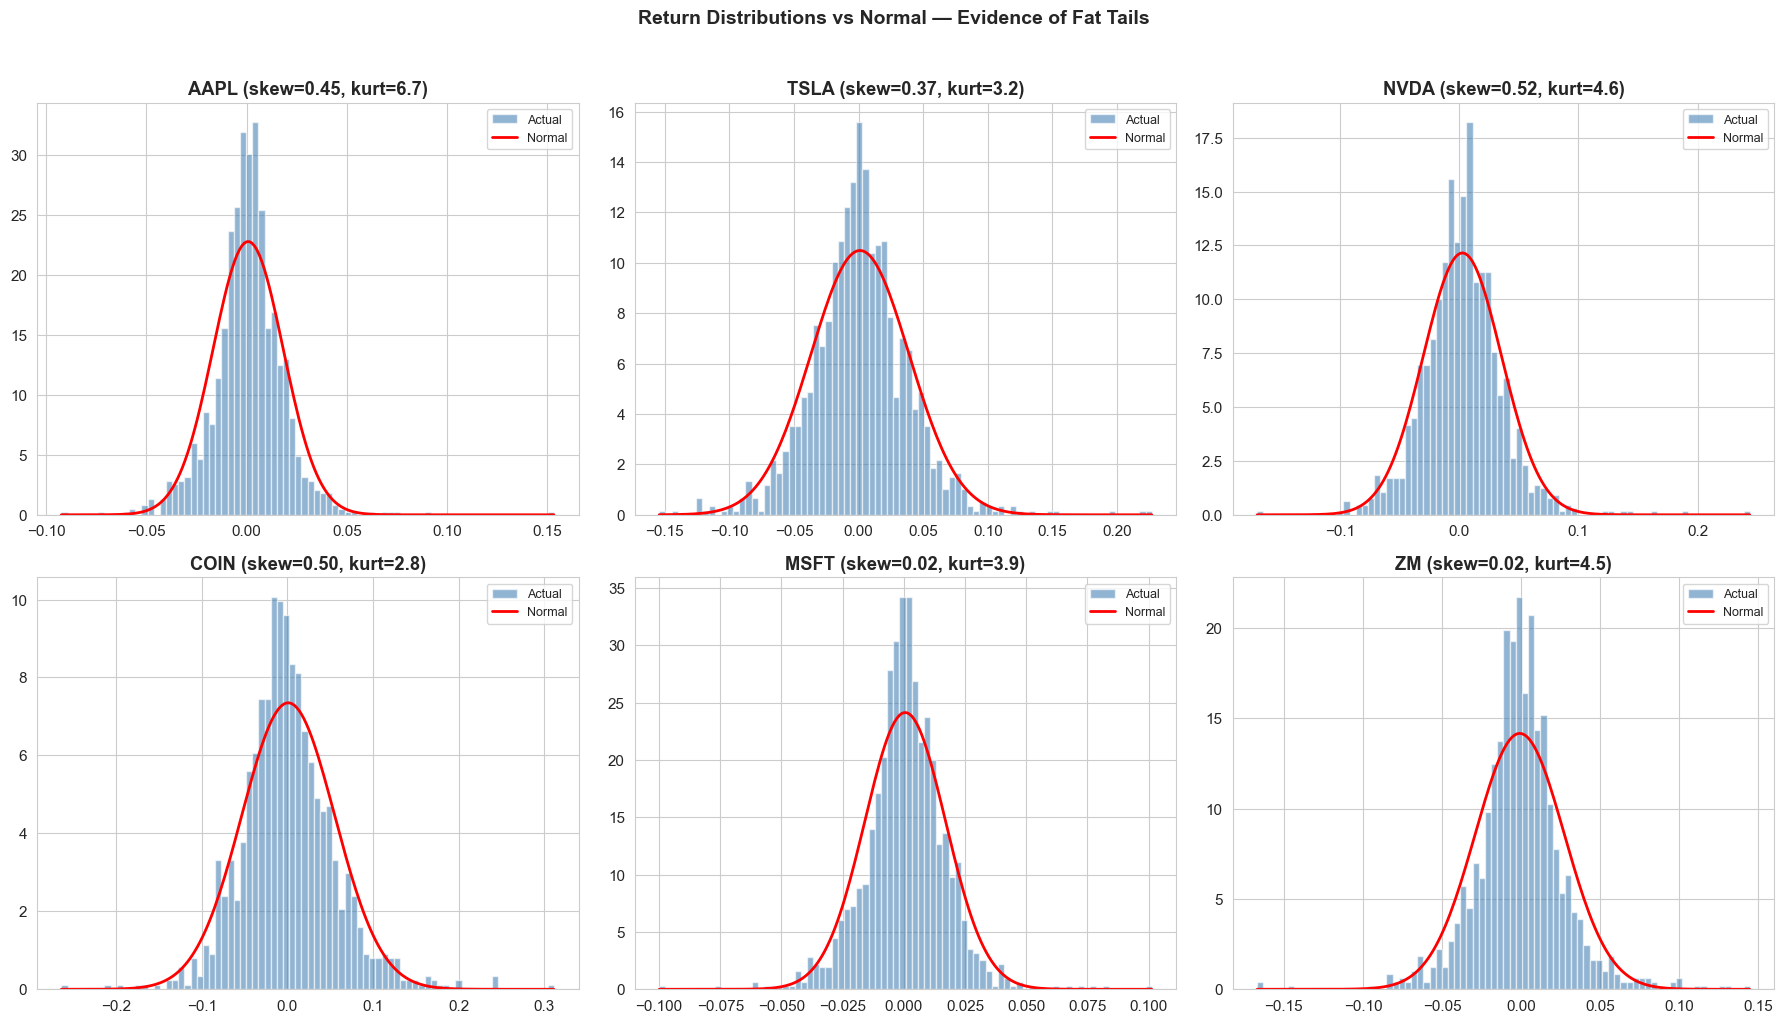

Average kurtosis: 9.21 (Normal = 0, higher = fatter tails)


In [6]:
# Return distributions vs Normal (fat tails evidence)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sample_stocks = ['AAPL', 'TSLA', 'NVDA', 'COIN', 'MSFT', 'ZM']

for i, symbol in enumerate(sample_stocks):
    ax = axes[i // 3, i % 3]
    returns = stock_data[stock_data['symbol'] == symbol]['daily_return'].dropna()
    ax.hist(returns, bins=80, density=True, alpha=0.6, color='steelblue', label='Actual')
    x = np.linspace(returns.min(), returns.max(), 200)
    ax.plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 'r-', linewidth=2, label='Normal')
    kurt = returns.kurtosis()
    skw = returns.skew()
    ax.set_title(f'{symbol} (skew={skw:.2f}, kurt={kurt:.1f})', fontweight='bold')
    ax.legend(fontsize=9)

plt.suptitle('Return Distributions vs Normal — Evidence of Fat Tails', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('return_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Average kurtosis: {return_stats["kurtosis"].mean():.2f} (Normal = 0, higher = fatter tails)')

---
## 4. Volatility Analysis

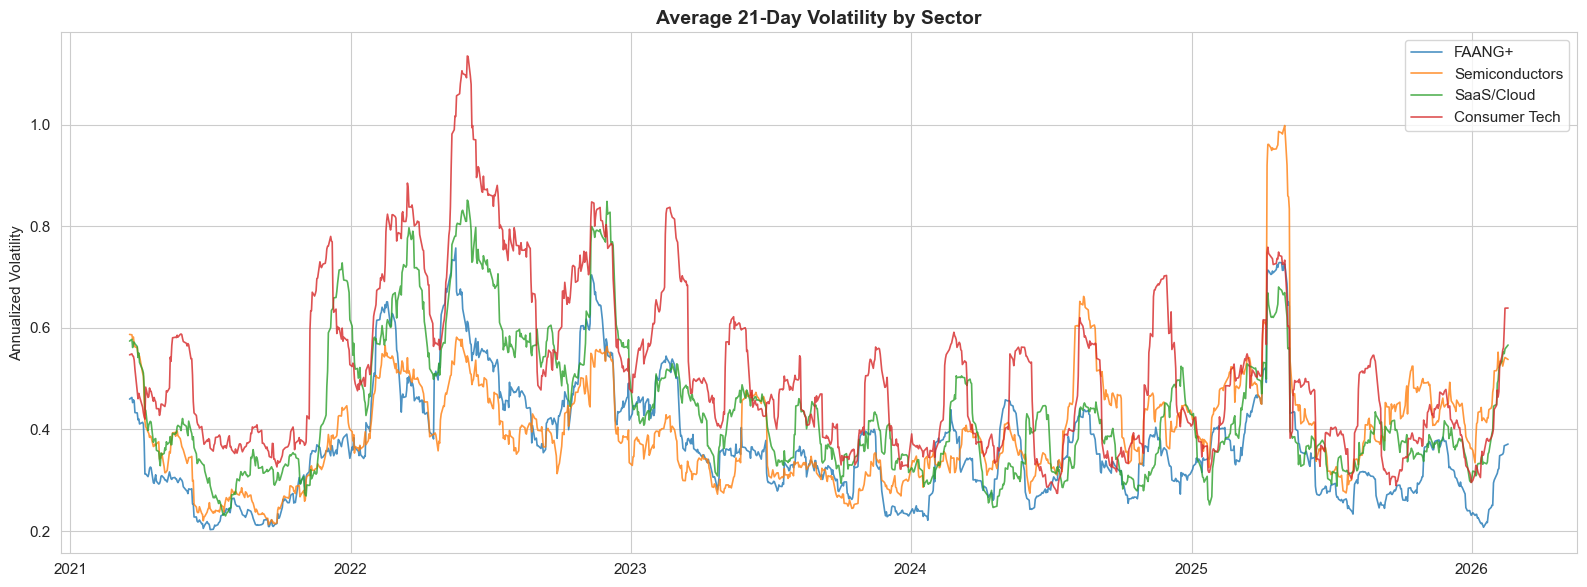

In [7]:
# Rolling volatility by sector
stock_data['vol_21d'] = stock_data.groupby('symbol')['daily_return'].transform(
    lambda x: x.rolling(21).std() * np.sqrt(252)
)

fig, ax = plt.subplots(figsize=(16, 6))
for sector, syms in SECTORS.items():
    sector_data = stock_data[stock_data['symbol'].isin(syms)]
    sector_vol = sector_data.groupby('date')['vol_21d'].mean()
    ax.plot(sector_vol.index, sector_vol.values, linewidth=1.2, alpha=0.8, label=sector)

ax.set_title('Average 21-Day Volatility by Sector', fontweight='bold', fontsize=14)
ax.set_ylabel('Annualized Volatility')
ax.legend()
plt.tight_layout()
plt.savefig('sector_volatility.png', dpi=150, bbox_inches='tight')
plt.show()

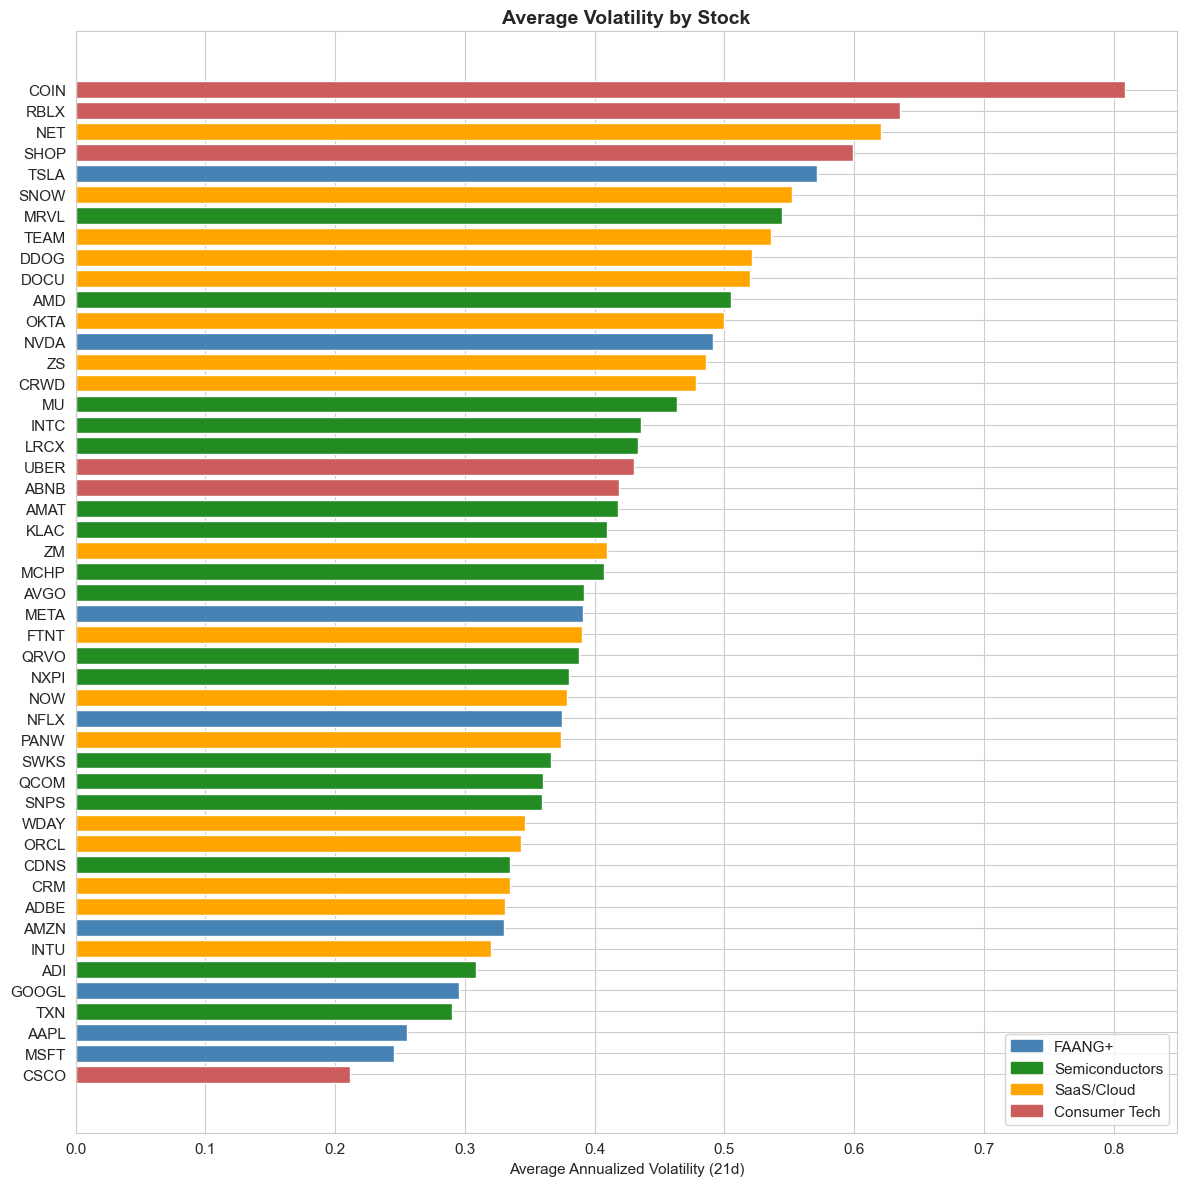

In [8]:
# Volatility ranking
avg_vol = stock_data.groupby('symbol')['vol_21d'].mean().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 12))
colors = [SECTOR_COLORS.get(symbol_to_sector.get(sym, ''), 'gray') for sym in avg_vol.index]
ax.barh(avg_vol.index, avg_vol.values, color=colors)
ax.set_xlabel('Average Annualized Volatility (21d)')
ax.set_title('Average Volatility by Stock', fontweight='bold', fontsize=14)
ax.legend(handles=[Patch(color=c, label=s) for s, c in SECTOR_COLORS.items()], loc='lower right')
plt.tight_layout()
plt.savefig('volatility_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Correlation Analysis

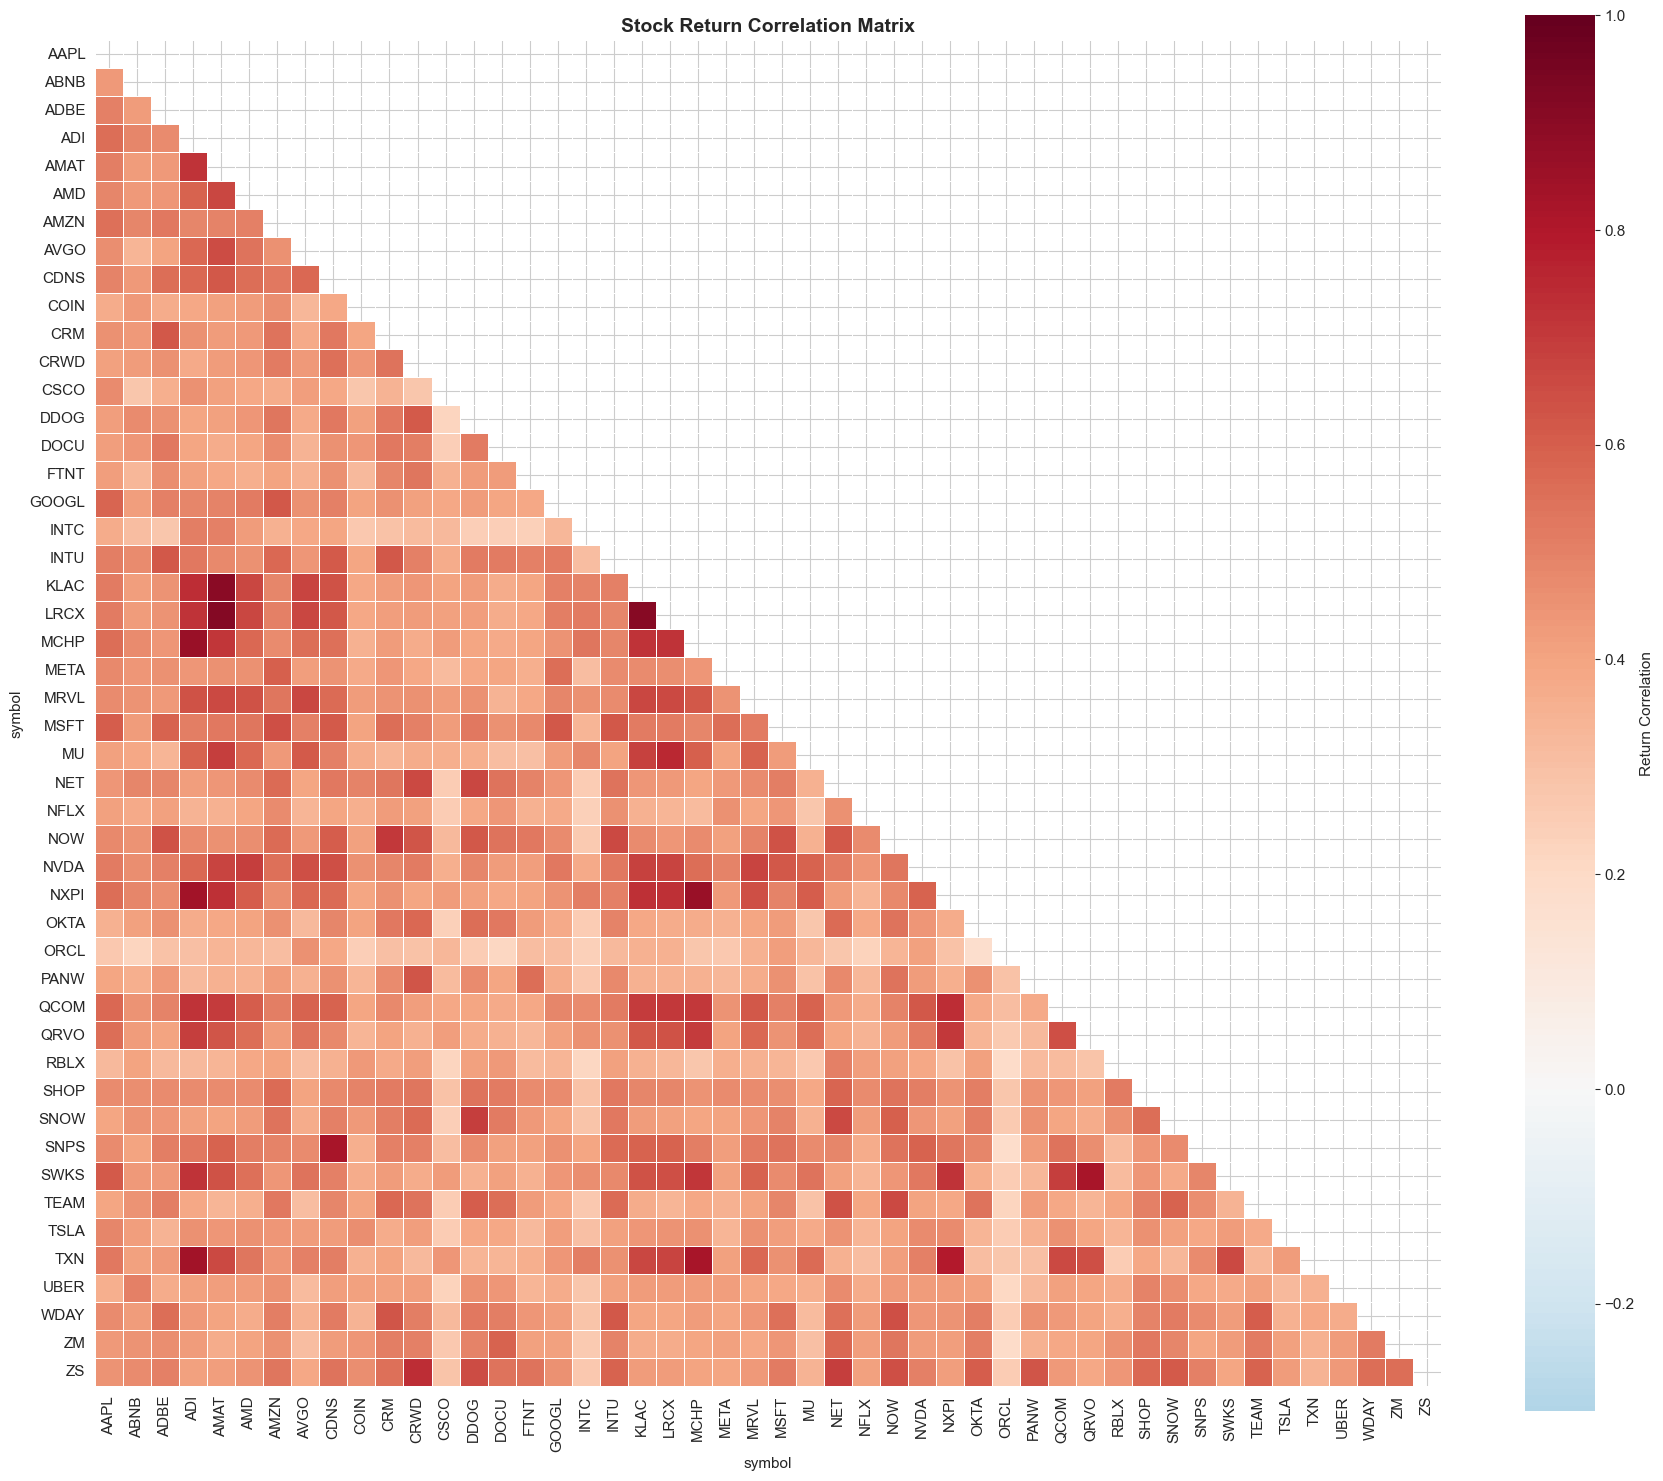

Most correlated (least diversifying):
symbol
CDNS    0.525392
AMAT    0.525664
NVDA    0.526262
LRCX    0.529695
KLAC    0.530912
dtype: float64

Least correlated (most diversifying):
symbol
ORCL    0.302145
CSCO    0.353887
INTC    0.363038
RBLX    0.371144
NFLX    0.393119
dtype: float64


In [9]:
# Return correlation matrix
returns_pivot = stock_data.pivot_table(index='date', columns='symbol', values='daily_return')
corr_matrix = returns_pivot.corr()

fig, ax = plt.subplots(figsize=(18, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, vmin=-0.3, vmax=1,
            ax=ax, square=True, linewidths=0.5, cbar_kws={'label': 'Return Correlation'})
ax.set_title('Stock Return Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_matrix_full.png', dpi=150, bbox_inches='tight')
plt.show()

avg_corr = corr_matrix.mean().sort_values()
print('Most correlated (least diversifying):')
print(avg_corr.tail(5))
print('\nLeast correlated (most diversifying):')
print(avg_corr.head(5))

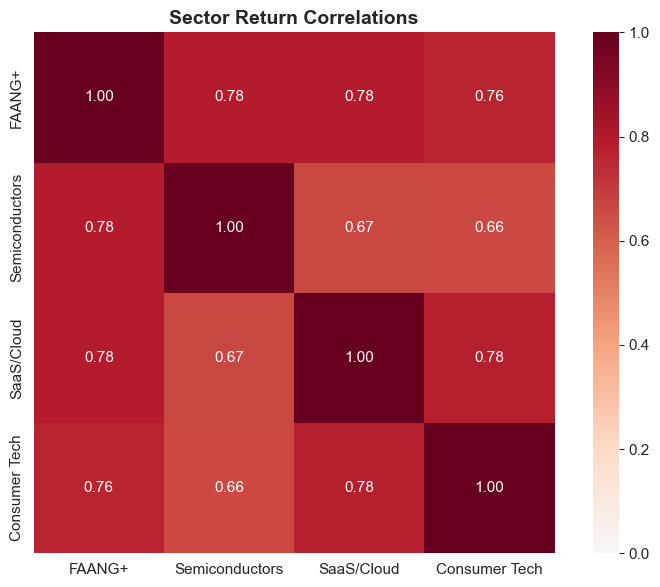

In [10]:
# Sector-level correlations
sector_returns = pd.DataFrame()
for sector, syms in SECTORS.items():
    available = [s for s in syms if s in returns_pivot.columns]
    sector_returns[sector] = returns_pivot[available].mean(axis=1)

sector_corr = sector_returns.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(sector_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True, vmin=0, vmax=1)
ax.set_title('Sector Return Correlations', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('sector_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Drawdown Analysis

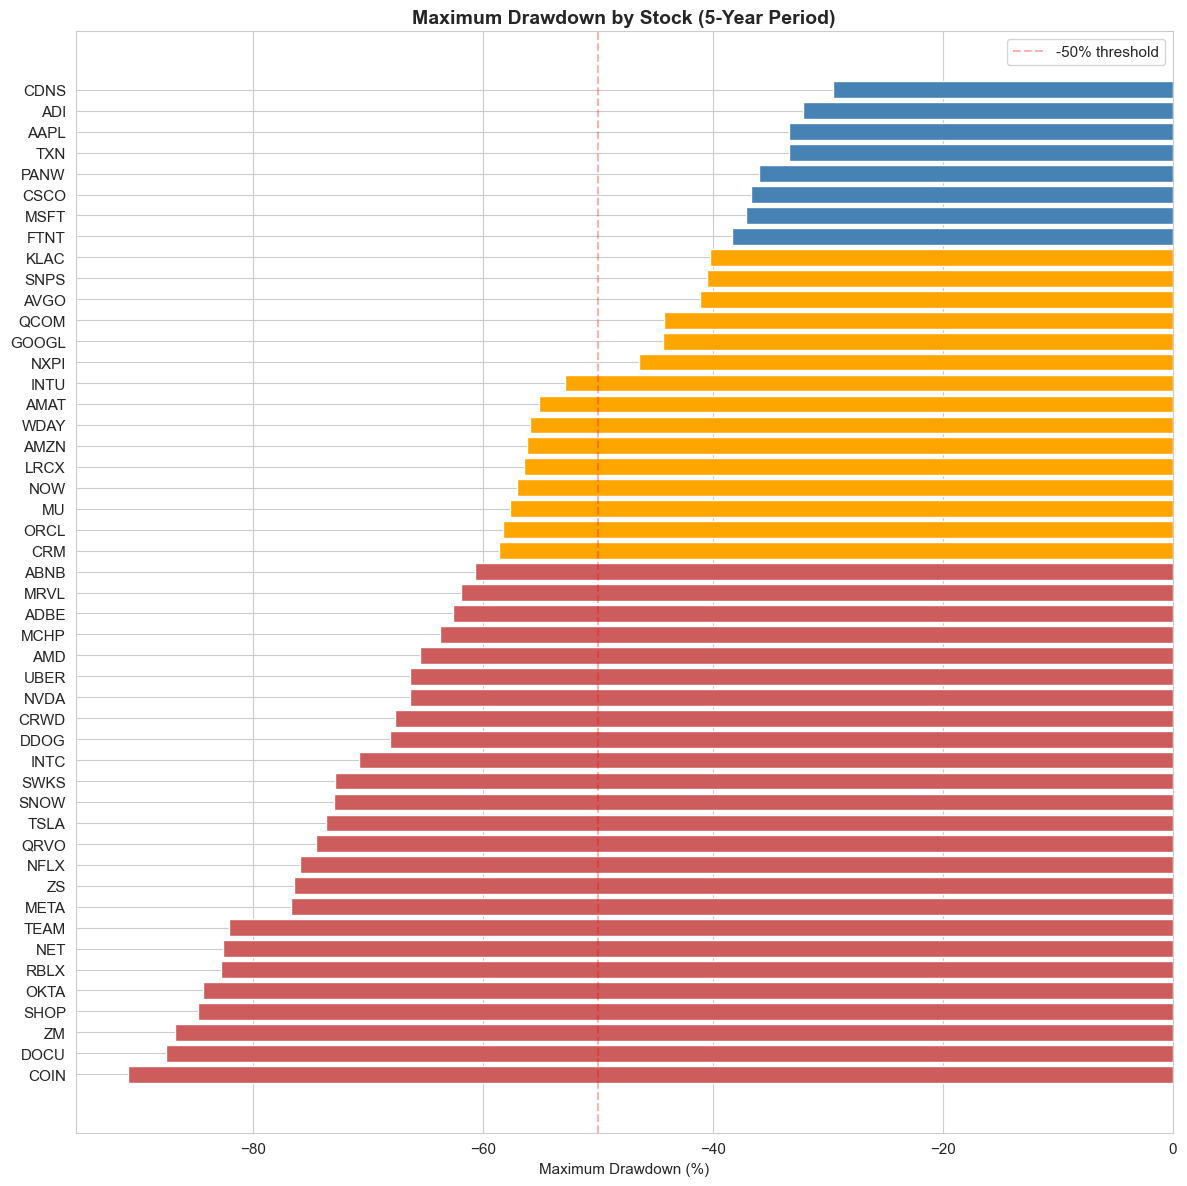

Average max drawdown: -60.43%
Worst: -90.90% (COIN)
Best: -29.59% (CDNS)


In [11]:
# Maximum drawdown per stock
def compute_max_drawdown(prices):
    peak = prices.cummax()
    drawdown = (prices - peak) / peak
    return drawdown.min()

max_dd = stock_data.groupby('symbol')['close'].apply(compute_max_drawdown).sort_values()

fig, ax = plt.subplots(figsize=(12, 12))
colors = ['indianred' if dd < -0.60 else 'orange' if dd < -0.40 else 'steelblue' for dd in max_dd.values]
ax.barh(max_dd.index, max_dd.values * 100, color=colors)
ax.set_xlabel('Maximum Drawdown (%)')
ax.set_title('Maximum Drawdown by Stock (5-Year Period)', fontweight='bold', fontsize=14)
ax.axvline(x=-50, color='red', linestyle='--', alpha=0.3, label='-50% threshold')
ax.legend()
plt.tight_layout()
plt.savefig('max_drawdowns.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Average max drawdown: {max_dd.mean():.2%}')
print(f'Worst: {max_dd.min():.2%} ({max_dd.idxmin()})')
print(f'Best: {max_dd.max():.2%} ({max_dd.idxmax()})')

---
## 7. Risk-Return Tradeoff

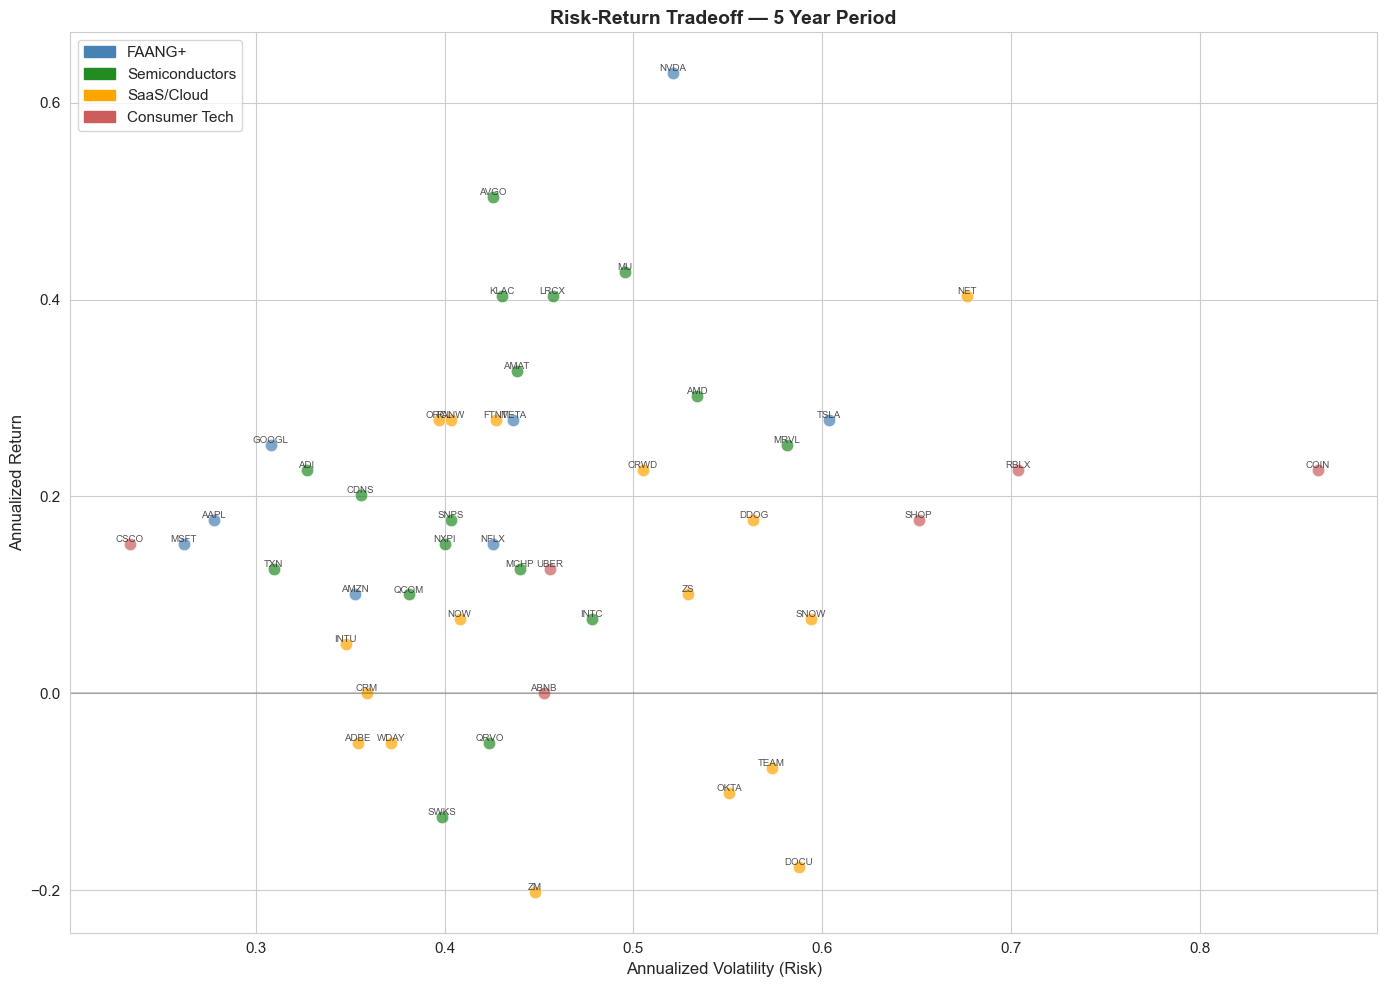

In [12]:
fig, ax = plt.subplots(figsize=(14, 10))

for sector, syms in SECTORS.items():
    for sym in syms:
        if sym in return_stats.index:
            row = return_stats.loc[sym]
            ax.scatter(row['annualized_vol'], row['annualized_return'],
                      color=SECTOR_COLORS[sector], s=80, alpha=0.7, edgecolors='white', linewidth=0.5)
            ax.annotate(sym, (row['annualized_vol'], row['annualized_return']),
                       fontsize=7, ha='center', va='bottom', alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax.set_xlabel('Annualized Volatility (Risk)', fontsize=12)
ax.set_ylabel('Annualized Return', fontsize=12)
ax.set_title('Risk-Return Tradeoff — 5 Year Period', fontweight='bold', fontsize=14)
ax.legend(handles=[Patch(color=c, label=s) for s, c in SECTOR_COLORS.items()], loc='upper left')
plt.tight_layout()
plt.savefig('risk_return_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Feature Engineering Rationale

We engineered 34 features across 7 categories for the risk classifier:

| Category | Count | Examples | Rationale |
|----------|-------|----------|-----------|
| Volatility | 6 | 21d vol, ATR, BB width | Core risk signal — vol clusters |
| Momentum | 7 | 5/10/21/63d returns, SMA cross | Trend and reversal signals |
| Technical | 7 | RSI, MACD, Bollinger %B | Classic quant indicators |
| Volume | 2 | Volume ratio, down-volume ratio | Unusual activity detection |
| Risk | 5 | Max drawdown, beta, 52w distance | Historical risk exposure |
| Cross-Sectional | 4 | Vol rank, return rank vs peers | Relative positioning |
| Market Regime | 3 | SPY vol, SPY return, high-vol flag | Systematic risk context |

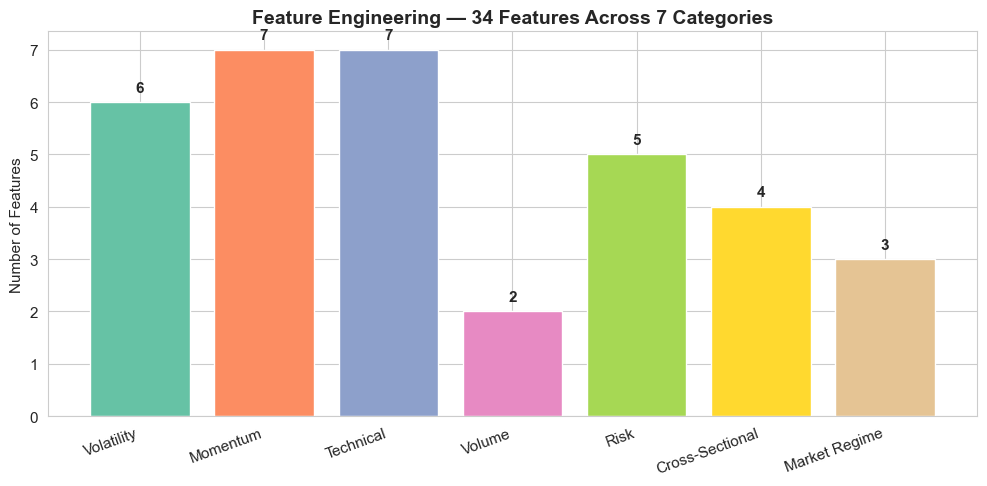

In [13]:
import json, os
MODEL_DIR = os.path.join('..', 'backend', 'models')

with open(os.path.join(MODEL_DIR, 'model_metadata.json')) as f:
    metadata = json.load(f)

feature_categories = {
    'Volatility': ['volatility_21d', 'volatility_63d', 'vol_change', 'atr_14', 'bb_width', 'beta_vol_interaction'],
    'Momentum': ['return_5d', 'return_10d', 'return_21d', 'return_63d', 'momentum_reversal', 'return_vol_adj', 'sma_cross'],
    'Technical': ['rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bb_position', 'rsi_overbought', 'rsi_oversold'],
    'Volume': ['volume_ratio', 'down_volume_ratio'],
    'Risk': ['max_drawdown_63d', 'beta_63d', 'dist_from_52w_high', 'dist_from_52w_low', 'consec_down'],
    'Cross-Sectional': ['volatility_21d_rank', 'return_21d_rank', 'beta_63d_rank', 'volume_ratio_rank'],
    'Market Regime': ['spy_vol_21d', 'spy_return_21d', 'high_vol_regime'],
}

fig, ax = plt.subplots(figsize=(10, 5))
cats = list(feature_categories.keys())
counts = [len(v) for v in feature_categories.values()]
colors_bar = sns.color_palette('Set2', len(cats))
ax.bar(cats, counts, color=colors_bar)
ax.set_ylabel('Number of Features')
ax.set_title('Feature Engineering — 34 Features Across 7 Categories', fontweight='bold', fontsize=14)
for i, (c, n) in enumerate(zip(cats, counts)):
    ax.text(i, n + 0.2, str(n), ha='center', fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('feature_categories.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Model Performance Summary

In [14]:
with open(os.path.join(MODEL_DIR, 'model_metadata.json')) as f:
    risk_meta = json.load(f)

vol_meta_path = os.path.join(MODEL_DIR, 'vol_model_metadata.json')
vol_meta = None
if os.path.exists(vol_meta_path):
    with open(vol_meta_path) as f:
        vol_meta = json.load(f)

print('=' * 65)
print('  MODEL PERFORMANCE SUMMARY')
print('=' * 65)

print(f'\n--- Risk Classifier (XGBoost) ---')
print(f'  Target:           {risk_meta["target"]}')
print(f'  Features:         {risk_meta["n_features"]}')
print(f'  Train samples:    {risk_meta["train_samples"]:,}')
print(f'  Test samples:     {risk_meta["test_samples"]:,}')
print(f'  AUC-ROC:          {risk_meta["auc_roc"]:.4f}')
print(f'  CV AUC:           {risk_meta["cv_auc_mean"]:.4f} +/- {risk_meta["cv_auc_std"]:.4f}')
print(f'  F1 Score:         {risk_meta["f1"]:.4f}')
print(f'  Train period:     {risk_meta["train_date_range"][0]} to {risk_meta["train_date_range"][1]}')
print(f'  Test period:      {risk_meta["test_date_range"][0]} to {risk_meta["test_date_range"][1]}')

if vol_meta:
    print(f'\n--- Volatility Forecasting ---')
    print(f'  GARCH(1,1):')
    print(f'    MAE:  {vol_meta["garch"]["mae"]:.4f}')
    print(f'    RMSE: {vol_meta["garch"]["rmse"]:.4f}')
    print(f'    Dir. Accuracy: {vol_meta["garch"]["directional_accuracy"]:.2%}')
    print(f'  LSTM:')
    print(f'    MAE:  {vol_meta["lstm"]["mae"]:.4f}')
    print(f'    RMSE: {vol_meta["lstm"]["rmse"]:.4f}')
    print(f'    Dir. Accuracy: {vol_meta["lstm"]["directional_accuracy"]:.2%}')

  MODEL PERFORMANCE SUMMARY

--- Risk Classifier (XGBoost) ---
  Target:           high_volatility_21d (top 30%)
  Features:         34
  Train samples:    43,676
  Test samples:     12,480
  AUC-ROC:          0.7286
  CV AUC:           0.8592 +/- 0.0254
  F1 Score:         0.5335
  Train period:     2021-05-19 to 2024-12-31
  Test period:      2025-01-02 to 2026-01-15

--- Volatility Forecasting ---
  GARCH(1,1):
    MAE:  0.1403
    RMSE: 0.1813
    Dir. Accuracy: 78.79%
  LSTM:
    MAE:  0.1276
    RMSE: 0.1769
    Dir. Accuracy: 63.31%


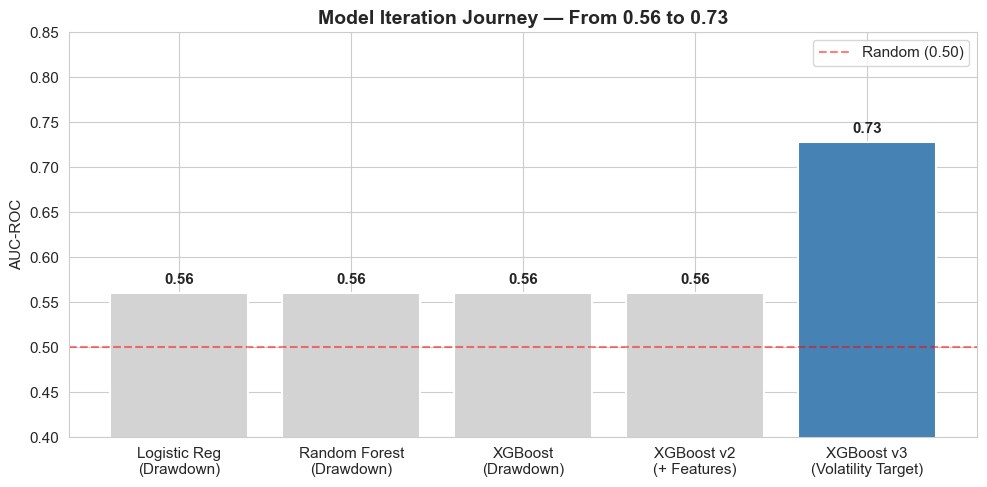

Key insight: Changing the target from drawdown to volatility was the breakthrough.
Volatility clusters (persists), making it learnable. Drawdowns are event-driven and noisy.


In [15]:
# Model iteration story — visual comparison
fig, ax = plt.subplots(figsize=(10, 5))

model_names = ['Logistic Reg\n(Drawdown)', 'Random Forest\n(Drawdown)', 'XGBoost\n(Drawdown)',
               'XGBoost v2\n(+ Features)', 'XGBoost v3\n(Volatility Target)']
auc_scores = [0.56, 0.56, 0.56, 0.56, risk_meta['auc_roc']]
colors_iter = ['#d3d3d3', '#d3d3d3', '#d3d3d3', '#d3d3d3', 'steelblue']

bars = ax.bar(model_names, auc_scores, color=colors_iter, edgecolor='white', linewidth=1.5)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (0.50)')
ax.set_ylabel('AUC-ROC')
ax.set_title('Model Iteration Journey — From 0.56 to 0.73', fontweight='bold', fontsize=14)
ax.set_ylim(0.4, 0.85)
ax.legend()

for bar, score in zip(bars, auc_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.2f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('model_iteration.png', dpi=150, bbox_inches='tight')
plt.show()

print('Key insight: Changing the target from drawdown to volatility was the breakthrough.')
print('Volatility clusters (persists), making it learnable. Drawdowns are event-driven and noisy.')

---
## 10. Model Explainability (SHAP)

SHAP values decompose each risk prediction into feature contributions. This is critical for regulatory compliance in finance (SR 11-7, Basel III) and building trust with portfolio managers.

In [16]:
# Load SHAP explanations
shap_path = os.path.join(MODEL_DIR, 'shap_explanations.json')
if os.path.exists(shap_path):
    with open(shap_path) as f:
        explanations = json.load(f)
    
    # Show top risk stocks with explanations
    sorted_stocks = sorted(explanations.items(), key=lambda x: x[1]['risk_probability'], reverse=True)
    
    print('Top 5 Highest Risk Stocks — SHAP Explanations:')
    print('=' * 70)
    for sym, exp in sorted_stocks[:5]:
        print(f'\n{sym} — Risk: {exp["risk_probability"]:.3f} ({exp["risk_level"]})')
        print(f'  Pushing risk UP:   {exp["risk_drivers_up"]}')
        print(f'  Pushing risk DOWN: {exp["risk_drivers_down"]}')
    
    print(f'\n\nTop 5 Lowest Risk Stocks:')
    print('=' * 70)
    for sym, exp in sorted_stocks[-5:]:
        print(f'\n{sym} — Risk: {exp["risk_probability"]:.3f} ({exp["risk_level"]})')
        print(f'  Pushing risk UP:   {exp["risk_drivers_up"]}')
        print(f'  Pushing risk DOWN: {exp["risk_drivers_down"]}')
else:
    print('SHAP explanations not found. Run Phase 2 notebook first.')

Top 5 Highest Risk Stocks — SHAP Explanations:

MU — Risk: 0.979 (High)
  Pushing risk UP:   atr_14 (+2.539), dist_from_52w_low (+0.590), return_63d (+0.450)
  Pushing risk DOWN: beta_63d (-0.171), sma_cross (-0.268), max_drawdown_63d (-0.349)

COIN — Risk: 0.975 (High)
  Pushing risk UP:   atr_14 (+2.789), max_drawdown_63d (+1.402), dist_from_52w_high (+0.524)
  Pushing risk DOWN: dist_from_52w_low (-0.298), spy_vol_21d (-0.380), vol_change (-0.637)

SNOW — Risk: 0.935 (High)
  Pushing risk UP:   atr_14 (+2.596), max_drawdown_63d (+0.623), macd_line (+0.164)
  Pushing risk DOWN: sma_cross (-0.126), vol_change (-0.333), spy_vol_21d (-0.376)

LRCX — Risk: 0.930 (High)
  Pushing risk UP:   atr_14 (+1.493), dist_from_52w_low (+0.377), return_63d (+0.341)
  Pushing risk DOWN: beta_63d (-0.102), sma_cross (-0.116), spy_vol_21d (-0.171)

RBLX — Risk: 0.926 (High)
  Pushing risk UP:   atr_14 (+2.547), max_drawdown_63d (+1.055), dist_from_52w_high (+0.464)
  Pushing risk DOWN: return_21d_rank 

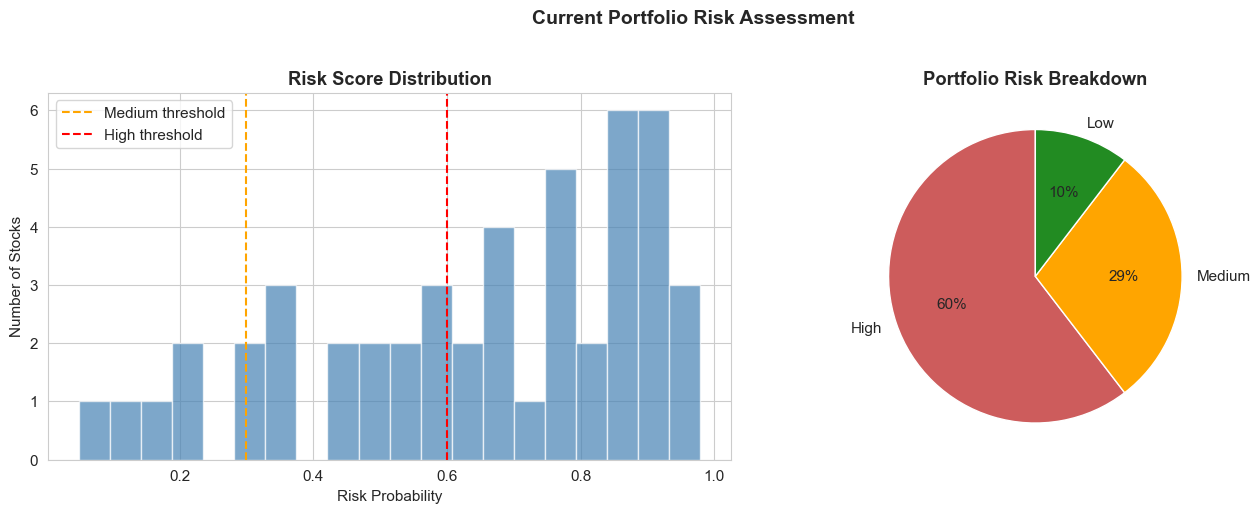

In [17]:
# Risk distribution across portfolio
if os.path.exists(shap_path):
    risk_probs = [v['risk_probability'] for v in explanations.values()]
    risk_levels = [v['risk_level'] for v in explanations.values()]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(risk_probs, bins=20, color='steelblue', alpha=0.7, edgecolor='white')
    axes[0].set_xlabel('Risk Probability')
    axes[0].set_ylabel('Number of Stocks')
    axes[0].set_title('Risk Score Distribution', fontweight='bold')
    axes[0].axvline(x=0.3, color='orange', linestyle='--', label='Medium threshold')
    axes[0].axvline(x=0.6, color='red', linestyle='--', label='High threshold')
    axes[0].legend()
    
    # Pie chart
    level_counts = pd.Series(risk_levels).value_counts()
    pie_colors = {'High': 'indianred', 'Medium': 'orange', 'Low': 'forestgreen'}
    axes[1].pie(level_counts.values, labels=level_counts.index, autopct='%1.0f%%',
               colors=[pie_colors.get(l, 'gray') for l in level_counts.index], startangle=90)
    axes[1].set_title('Portfolio Risk Breakdown', fontweight='bold')
    
    plt.suptitle('Current Portfolio Risk Assessment', fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('portfolio_risk.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 11. Conclusions & Future Work

### What Worked
- **Volatility as target** — Much more predictable than raw drawdowns (AUC 0.73 vs 0.56)
- **Cross-sectional features** — Ranking stocks against peers adds meaningful signal
- **Market regime features** — SPY volatility captures systematic risk shifts
- **SHAP explainability** — Provides per-stock actionable risk explanations

### What Could Improve
- **More data sources** — Options implied volatility, earnings dates, macro indicators
- **Longer history** — 10+ years would capture multiple market cycles
- **Sector diversity** — Current universe is tech-heavy; adding healthcare, energy, financials would test generalization
- **Ensemble methods** — Combine GARCH and LSTM forecasts for improved volatility prediction

### Technical Stack
| Component | Technology |
|-----------|------------|
| Data Pipeline | Python, Yahoo Finance API, BeautifulSoup |
| Database | PostgreSQL (SQLAlchemy ORM) |
| ML Models | XGBoost, GARCH (arch), LSTM (TensorFlow) |
| NLP | FinBERT sentiment, FAISS vector search, LangChain RAG |
| LLM | Groq API (llama-3.3-70B) |
| Backend | Flask REST API |
| Frontend | React, Recharts, TailwindCSS |
| Explainability | SHAP (TreeExplainer) |

### Business Value
This platform provides:
1. **Automated risk monitoring** — Replaces manual spreadsheet-based tracking
2. **Explainable ML scores** — Every risk score has a SHAP-based explanation
3. **Forward-looking signals** — Volatility forecasts predict risk before it materializes
4. **AI-powered analysis** — Natural language interface for non-technical stakeholders
5. **Real-time alerts** — Automated detection of risk regime changes